In [2]:
# Checagem de ambiente

import sys, platform, warnings, os, json, random, math
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import gensim
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

warnings.filterwarnings("ignore")
matplotlib.rcParams["figure.dpi"] = 120

print("Python:", sys.version)
print("OS:", platform.platform())
print("gensim:", gensim.__version__)
print("pyLDAvis:", pyLDAvis.__version__)
print("numpy:", np.__version__)
print("matplotlib:", matplotlib.__version__)

Python: 3.12.2 (tags/v3.12.2:6abddd9, Feb  6 2024, 21:26:36) [MSC v.1937 64 bit (AMD64)]
OS: Windows-10-10.0.19045-SP0
gensim: 4.3.3
pyLDAvis: 3.4.0
numpy: 1.26.4
matplotlib: 3.9.0


In [3]:
# Definição de paths

from pathlib import Path

def find_repo_root(start: Path = Path.cwd()) -> Path:
    for p in [start, *start.parents]:
        target = p / "data" / "interim" / "lda" / "vocab_bow.dict"
        if target.exists():
            return p
    raise FileNotFoundError(
        "Raiz do projeto não encontrada. "
        "Verifique se existe 'data/interim/lda/vocab_bow.dict' a partir da raiz."
    )

REPO = find_repo_root()
print("REPO =", REPO)

# Entradas
PATH_BOW_MM         = REPO / "data" / "interim" / "lda" / "bow.mm"
PATH_VOCAB_DICT     = REPO / "data" / "interim" / "lda" / "vocab_bow.dict"
PATH_BOW_INDEX_CSV  = REPO / "data" / "interim" / "lda" / "bow_index.csv"
PATH_VOCAB_TERMS    = REPO / "data" / "interim" / "lda" / "vocab_terms.csv"

# Saídas
DIR_PROCESSED_LDA   = REPO / "data" / "processed" / "lda"
DIR_REPORTS_FIGS    = REPO / "reports" / "figs"
DIR_PROCESSED_LDA.mkdir(parents=True, exist_ok=True)
DIR_REPORTS_FIGS.mkdir(parents=True, exist_ok=True)

for p in [PATH_VOCAB_DICT, PATH_BOW_MM, PATH_BOW_INDEX_CSV, PATH_VOCAB_TERMS]:
    print(p, "EXISTS?", p.exists())

REPO = c:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc
c:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc\data\interim\lda\vocab_bow.dict EXISTS? True
c:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc\data\interim\lda\bow.mm EXISTS? True
c:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc\data\interim\lda\bow_index.csv EXISTS? True
c:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc\data\interim\lda\vocab_terms.csv EXISTS? True


In [4]:
# Carregar corpus e dicionário

dictionary = corpora.Dictionary.load(str(PATH_VOCAB_DICT))
corpus = corpora.MmCorpus(str(PATH_BOW_MM))

bow_index = pd.read_csv(PATH_BOW_INDEX_CSV)
vocab_df  = pd.read_csv(PATH_VOCAB_TERMS)

print(dictionary)
print(f"n_docs (corpus): {len(corpus)}")
bow_index.head(3)

Dictionary<1218 unique tokens: ['agendamento', 'atividade', 'avaliar', 'caso', 'cliente']...>
n_docs (corpus): 423


,row_idx,DOC_ID
0,0,0
1,1,1
2,2,2


In [5]:
# Utilitários (treino, coerências, estabilidade)

from typing import Dict, List
from itertools import combinations

RANDOM_STATE = 42

def train_lda(k:int,
              corpus,
              dictionary,
              passes:int=10,
              iterations:int=400,
              chunksize:int=2000,
              alpha='auto',
              eta='auto',
              random_state:int=RANDOM_STATE) -> LdaModel:
    return LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=k,
        random_state=random_state,
        chunksize=chunksize,
        passes=passes,
        iterations=iterations,
        alpha=alpha,
        eta=eta,
        eval_every=None
    )

def compute_coherences(model:LdaModel,
                       texts_like_tokens:List[List[str]]|None,
                       corpus,
                       dictionary,
                       topn:int=10,
                       window_size:int=110) -> Dict[str, float]:
    """
    Calcula U_Mass, C_v e C_npmi com proteção contra NaN/inf.
    Força processes=1 (Windows/Py3.12) para evitar instabilidades conhecidas.
    """
    coherences = {}

    # UMass
    cm_umass = CoherenceModel(model=model, corpus=corpus, dictionary=dictionary,
                              coherence='u_mass', topn=topn, processes=1)
    val_umass = cm_umass.get_coherence()
    coherences['u_mass'] = float(val_umass) if np.isfinite(val_umass) else float('nan')

    # C_v
    if texts_like_tokens is not None:
        cm_cv = CoherenceModel(model=model, texts=texts_like_tokens, dictionary=dictionary,
                               coherence='c_v', topn=topn, window_size=window_size, processes=1)
    else:
        cm_cv = CoherenceModel(model=model, corpus=corpus, dictionary=dictionary,
                               coherence='c_v', topn=topn, window_size=window_size, processes=1)
    val_cv = cm_cv.get_coherence()
    coherences['c_v'] = float(val_cv) if np.isfinite(val_cv) else float('nan')

    # C_npmi
    if texts_like_tokens is not None:
        cm_npmi = CoherenceModel(model=model, texts=texts_like_tokens, dictionary=dictionary,
                                 coherence='c_npmi', topn=topn, window_size=window_size, processes=1)
        val_npmi = cm_npmi.get_coherence()
        coherences['c_npmi'] = float(val_npmi) if np.isfinite(val_npmi) else float('nan')
    else:
        coherences['c_npmi'] = float('nan')

    return coherences

def topn_terms_per_topic(model:LdaModel, topn:int=10) -> Dict[int, List[str]]:
    return {t: [w for (w, _) in model.show_topic(t, topn=topn)] for t in range(model.num_topics)}

def jaccard(a:set, b:set) -> float:
    u = len(a | b)
    return len(a & b)/u if u else 0.0

def stability_score(models:List[LdaModel], topn:int=10) -> float:
    if len(models) < 2:
        return float('nan')

    def pairwise_best_match(m1, m2):
        T1 = topn_terms_per_topic(m1, topn=topn)
        T2 = topn_terms_per_topic(m2, topn=topn)
        used = set()
        scores = []
        for t1, terms1 in T1.items():
            s1 = set(terms1)
            best, best_t = 0.0, None
            for t2, terms2 in T2.items():
                if t2 in used:
                    continue
                sc = jaccard(s1, set(terms2))
                if sc > best:
                    best, best_t = sc, t2
            if best_t is not None:
                used.add(best_t)
                scores.append(best)
        return float(np.mean(scores)) if scores else 0.0

    vals = []
    for i, j in combinations(range(len(models)), 2):
        vals.append(pairwise_best_match(models[i], models[j]))
    return float(np.mean(vals)) if vals else float('nan')


In [6]:
# Carregar tokens para coerência

import pickle

TOKENS_PATH = REPO / "data" / "interim" / "lda" / "tokens.pkl"

if TOKENS_PATH.exists():
    with open(TOKENS_PATH, "rb") as f:
        texts_like_tokens = pickle.load(f)
    print("Tokens carregados:", len(texts_like_tokens))
else:
    texts_like_tokens = None
    print("Aviso: tokens.pkl não encontrado, coerência C_v/C_npmi pode ficar limitada.")

Tokens carregados: 423


In [7]:
# Varredura de k

K_VALUES = list(range(5, 35, 5))
PASSES = 10
ITERATIONS = 400
CHUNKSIZE = 2000
N_RESTARTS = 3
random_seeds = [RANDOM_STATE + i for i in range(N_RESTARTS)]

results = []
best_models_per_k = {}

for k in K_VALUES:
    models_k, metrics_k = [], []
    for seed in random_seeds:
        model = train_lda(k, corpus, dictionary,
                          passes=PASSES, iterations=ITERATIONS,
                          chunksize=CHUNKSIZE, random_state=seed)
        coh = compute_coherences(model, texts_like_tokens, corpus, dictionary)
        # sanitiza NaN/inf antes de agregar
        for mkey in ["u_mass", "c_v", "c_npmi"]:
            if (mval := coh.get(mkey, np.nan)) is None or (not np.isfinite(mval)):
                coh[mkey] = float('nan')
        models_k.append(model)
        metrics_k.append(coh)

    stab = stability_score(models_k, topn=10)

    dfm = pd.DataFrame(metrics_k).replace([np.inf, -np.inf], np.nan)
    # modelo "representativo" do k: o de maior C_v válido; se todos NaN, fica o primeiro
    idx_best = dfm["c_v"].idxmax() if dfm["c_v"].notna().any() else 0
    best_models_per_k[k] = models_k[int(idx_best)]

    mean_metrics = dfm.mean(numeric_only=True).to_dict()
    mean_metrics["stability_jaccard_top10"] = float(stab) if np.isfinite(stab) else float('nan')
    mean_metrics["k"] = k
    results.append(mean_metrics)

metrics_df = pd.DataFrame(results).sort_values("k").reset_index(drop=True)
metrics_df

,u_mass,c_v,c_npmi,stability_jaccard_top10,k
0,-1.402942,0.392291,0.030920,0.386307,5
1,-1.984136,0.389784,0.029894,0.273718,10
2,-2.136946,0.379276,0.018692,0.251704,15
3,-2.596010,NaN,NaN,0.221009,20
4,-2.807967,NaN,NaN,0.225180,25
5,-2.757809,0.346930,0.000169,0.226987,30


In [8]:
# Decisor objetivo: C_v primário + estabilidade + parcimônia

TOL = 0.003  # tolerância de "empate" em C_v (ajuste p/ 0.003–0.005 se desejar)

df = metrics_df.replace([np.inf, -np.inf], np.nan).copy()
best_cv = df["c_v"].max(skipna=True)
df["cv_delta_to_best"] = best_cv - df["c_v"]

# Candidatos: C_v dentro da tolerância do melhor
cands = df[df["cv_delta_to_best"] <= TOL].copy()

if not cands.empty:
    # Desempate 1: maior estabilidade; Desempate 2: menor k
    max_stab = cands["stability_jaccard_top10"].max(skipna=True)
    cands2 = cands[cands["stability_jaccard_top10"] == max_stab]
    k_recommended = int(cands2["k"].min())
else:
    # Sem candidatos próximos ao melhor C_v: usa argmax de C_v (ignorando NaN)
    k_recommended = int(df.loc[df["c_v"].idxmax(), "k"])

display(df.sort_values("k"))
print(f"\nRecomendação (C_v±{TOL} + estabilidade + parcimônia): k = {k_recommended}")

# Opcional: para forçar o uso desta recomendação em vez do pick_k padrão, descomente:
k_star = k_recommended
best_model = best_models_per_k[k_star]

,u_mass,c_v,c_npmi,stability_jaccard_top10,k,cv_delta_to_best
0,-1.402942,0.392291,0.030920,0.386307,5,0.000000
1,-1.984136,0.389784,0.029894,0.273718,10,0.002506
2,-2.136946,0.379276,0.018692,0.251704,15,0.013014
3,-2.596010,NaN,NaN,0.221009,20,NaN
4,-2.807967,NaN,NaN,0.225180,25,NaN
5,-2.757809,0.346930,0.000169,0.226987,30,0.045360



Recomendação (C_v±0.003 + estabilidade + parcimônia): k = 5


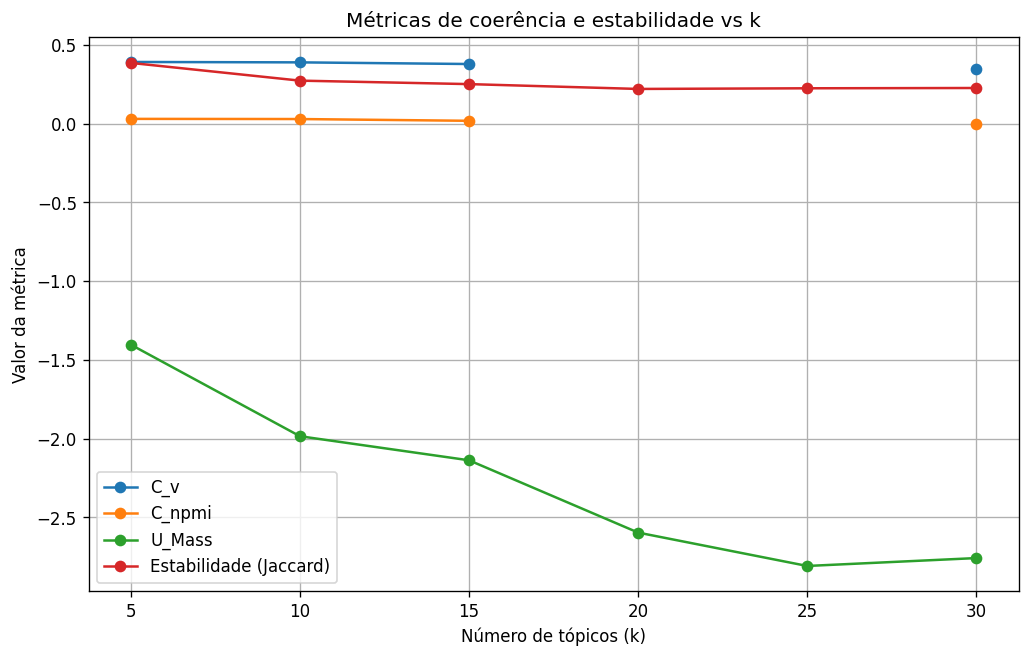

Figura de diagnóstico salva em: c:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc\reports\figs\lda_k_diagnostics.png


In [9]:
# Gráfico de métricas de coerência e estabilidade em função de k

plt.figure(figsize=(10, 6))
plt.plot(metrics_df["k"], metrics_df["c_v"], marker="o", label="C_v")
plt.plot(metrics_df["k"], metrics_df["c_npmi"], marker="o", label="C_npmi")
plt.plot(metrics_df["k"], metrics_df["u_mass"], marker="o", label="U_Mass")
plt.plot(metrics_df["k"], metrics_df["stability_jaccard_top10"], marker="o", label="Estabilidade (Jaccard)")

plt.xlabel("Número de tópicos (k)")
plt.ylabel("Valor da métrica")
plt.title("Métricas de coerência e estabilidade vs k")
plt.legend()
plt.grid(True)

DIAG_PNG = DIR_REPORTS_FIGS / "lda_k_diagnostics.png"
plt.savefig(DIAG_PNG, bbox_inches="tight")
plt.show()

print("Figura de diagnóstico salva em:", DIAG_PNG)

In [10]:
# Seleção do melhor k e salvamento do modelo

def pick_k(df:pd.DataFrame) -> int:
    """
    Seleciona k* priorizando C_v (Röder et al., 2015).
    Desempate:
      1) maior estabilidade_jaccard_top10 (tópicos mais estáveis),
      2) menor k (princípio de parcimônia).
    Ignora valores inf/NaN em C_npmi no desempate.
    """
    d = df.copy()
    d = d.replace([np.inf, -np.inf], np.nan)

    # 1) filtra linhas com C_v válido
    mask_cv = d["c_v"].notna()
    if mask_cv.any():
        top_cv = d.loc[mask_cv, "c_v"].max()
        cands = d[(d["c_v"] == top_cv)]
        # 1a) desempate por estabilidade (se existir e não-NaN)
        if "stability_jaccard_top10" in cands and cands["stability_jaccard_top10"].notna().any():
            best_idx = cands["stability_jaccard_top10"].idxmax()
            return int(d.loc[best_idx, "k"])
        # 1b) parcimônia: menor k entre os candidatos
        return int(cands["k"].min())

    # 2) sem C_v válido: tenta C_npmi válido
    if "c_npmi" in d and d["c_npmi"].notna().any():
        top_npmi = d["c_npmi"].max()
        cands = d[d["c_npmi"] == top_npmi]
        if "stability_jaccard_top10" in cands and cands["stability_jaccard_top10"].notna().any():
            best_idx = cands["stability_jaccard_top10"].idxmax()
            return int(d.loc[best_idx, "k"])
        return int(cands["k"].min())

    # 3) fallback: maior C_v (mesmo NaN geral) ou simplesmente menor k disponível
    return int(d["k"].min()) if "k" in d else 10

k_star = pick_k(metrics_df)
best_model = best_models_per_k[k_star]
print(f"Melhor k selecionado: {k_star}")

MODEL_PATH = DIR_PROCESSED_LDA / "model.lda"
best_model.save(str(MODEL_PATH))

METRICS_CSV = DIR_PROCESSED_LDA / "coherences.csv"
metrics_df.to_csv(METRICS_CSV, index=False)

print("Modelo salvo em:", MODEL_PATH)
print("Métricas salvas em:", METRICS_CSV)


Melhor k selecionado: 5
Modelo salvo em: c:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc\data\processed\lda\model.lda
Métricas salvas em: c:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc\data\processed\lda\coherences.csv


In [11]:
# Salvamento de artefatos LDA (phi, theta, top-words JSON)

import json
import numpy as np
import pandas as pd
import warnings

# Sanidade básica
assert 'best_model' in globals(), "best_model inexistente — rode a célula de seleção do melhor k primeiro."
assert 'corpus' in globals(), "corpus inexistente — rode as células de carregamento do corpus."
assert 'dictionary' in globals(), "dictionary inexistente — rode as células de carregamento do dicionário."
assert 'DIR_PROCESSED_LDA' in globals(), "DIR_PROCESSED_LDA inexistente — rode a célula de paths."

DIR_PROCESSED_LDA.mkdir(parents=True, exist_ok=True)

# 0) Vocabulário em texto (um termo por linha, ordenado por id)
VOCAB_TXT = DIR_PROCESSED_LDA / "vocab.txt"
id2token = [t for t,_id in sorted(dictionary.token2id.items(), key=lambda kv: kv[1])]
with open(VOCAB_TXT, "w", encoding="utf-8") as f:
    f.write("\n".join(map(str, id2token)))

# 1) φ (topic-word distributions): shape (K, |V|)
PHI_PATH = DIR_PROCESSED_LDA / "phi_topics.npy"
phi = best_model.get_topics()  # ndarray (K x |V|)
np.save(PHI_PATH, phi)

# 2) θ (document-topic distributions): shape (n_docs, K)
THETA_PATH = DIR_PROCESSED_LDA / "theta_docs.npy"
n_docs = len(corpus)
K = best_model.num_topics
theta = np.zeros((n_docs, K), dtype=np.float32)
for i, bow in enumerate(corpus):
    # minimum_probability=0.0 para vetor denso
    for k, p in best_model.get_document_topics(bow, minimum_probability=0.0):
        theta[i, k] = p
np.save(THETA_PATH, theta)

# 3) Top-words por tópico em JSON (top-10 com pesos)
TOPWORDS_JSON = DIR_PROCESSED_LDA / "topics_top_words.json"
topn = 10
topics_json = []
for t in range(K):
    terms = best_model.show_topic(t, topn=topn)  # [(word, weight), ...]
    terms = [(str(w), float(wt)) for (w, wt) in terms]  # normaliza tipos p/ JSON
    topics_json.append({"topic_id": int(t), "top_words": terms})

with open(TOPWORDS_JSON, "w", encoding="utf-8") as f:
    json.dump(topics_json, f, ensure_ascii=False, indent=2)

# (Opcional) checagem de alinhamento com índice de docs, se existir
try:
    PATH_BOW_INDEX_CSV  # se não existir, NameError e cai no except
    bow_index = pd.read_csv(PATH_BOW_INDEX_CSV)
    assert len(bow_index) == n_docs, f"bow_index ({len(bow_index)}) != n_docs do corpus ({n_docs})"
except Exception as e:
    warnings.warn(f"Não foi possível validar bow_index vs corpus: {e}")

print(
    "Salvos:\n"
    f"- vocab.txt: {VOCAB_TXT}\n"
    f"- φ (K x |V|): {PHI_PATH}\n"
    f"- θ (n_docs x K): {THETA_PATH}\n"
    f"- top-words JSON: {TOPWORDS_JSON}"
)

Salvos:
- vocab.txt: c:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc\data\processed\lda\vocab.txt
- φ (K x |V|): c:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc\data\processed\lda\phi_topics.npy
- θ (n_docs x K): c:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc\data\processed\lda\theta_docs.npy
- top-words JSON: c:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc\data\processed\lda\topics_top_words.json


In [14]:
# Exportar a tabela doc–tópico do LDA (top1, prob_top1, margem)
import numpy as np, pandas as pd

# pré-requisitos: best_model, corpus, PATH_BOW_INDEX_CSV, REPO, DIR_PROCESSED_LDA já definidos

# 1) Distribuições doc→tópico
rows = []
for i, bow in enumerate(corpus):
    dist = best_model.get_document_topics(bow, minimum_probability=0.0)
    probs = np.array([p for _, p in dist], dtype=float)
    top1 = int(np.argmax(probs)) if probs.size else -1
    top1_p = float(probs[top1]) if probs.size else 0.0
    top2_p = float(np.partition(probs, -2)[-2]) if probs.size > 1 else 0.0
    rows.append((i, top1, top1_p, top1_p - top2_p))

dx = pd.DataFrame(rows, columns=["row", "topic", "prob_top1", "margin"])

# 2) Mapear DOC_ID (sem depender de 'pos')
bow_index = pd.read_csv(PATH_BOW_INDEX_CSV)  # deve ter ao menos 'DOC_ID'
if "DOC_ID" not in bow_index.columns:
    raise KeyError(f"'DOC_ID' não encontrado em {PATH_BOW_INDEX_CSV}. Colunas: {list(bow_index.columns)}")

if "pos" in bow_index.columns:
    # caminho A: se existir 'pos', use-o
    map_df = bow_index[["pos", "DOC_ID"]].copy()
    dx = dx.merge(map_df, left_on="row", right_on="pos", how="left").drop(columns=["row","pos"])
else:
    # caminho B: alinhar pela ordem das linhas
    bow_index = bow_index.reset_index(drop=False).rename(columns={"index":"row"})
    map_df = bow_index[["row","DOC_ID"]].copy()
    dx = dx.merge(map_df, on="row", how="left").drop(columns=["row"])

# 3) Anexar metadados disponíveis do prep
prep_path = REPO / "data" / "interim" / "lda" / "prep.csv"
# lê só as colunas que existirem
head_cols = pd.read_csv(prep_path, nrows=0).columns
use_cols = [c for c in ["DOC_ID","ano","titulo","orientador"] if c in head_cols]
prep = pd.read_csv(prep_path, usecols=use_cols) if use_cols else pd.DataFrame()

if not prep.empty:
    dx = dx.merge(prep, on="DOC_ID", how="left")

# 4) Persistir
OUT = DIR_PROCESSED_LDA / "doc_topics.csv"
dx.to_csv(OUT, index=False, encoding="utf-8")
print(f"Salvo: {OUT} | linhas: {len(dx)} | colunas: {list(dx.columns)}")

Salvo: c:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc\data\processed\lda\doc_topics.csv | linhas: 423 | colunas: ['topic', 'prob_top1', 'margin', 'DOC_ID', 'ano', 'titulo', 'orientador']


In [ ]:
# Análise de robustez de k: inspeção da estabilidade relativa

plt.figure(figsize=(8, 5))
plt.plot(metrics_df["k"], metrics_df["stability_jaccard_top10"], marker="s", color="darkred")
plt.xlabel("Número de tópicos (k)")
plt.ylabel("Estabilidade média (Jaccard top-10 termos)")
plt.title("Robustez da escolha de k: estabilidade entre reinicializações")
plt.grid(True)

ROBUST_PNG = DIR_REPORTS_FIGS / "lda_k_robustness.png"
plt.savefig(ROBUST_PNG, bbox_inches="tight")
plt.show()

print("Figura de robustez salva em:", ROBUST_PNG)

In [ ]:
# Nitidez doc–tópico por k: proporção média do tópico dominante (maior = mais nítido)

def dominant_topic_prop(model: LdaModel, corpus) -> float:
    vals = []
    for bow in corpus:
        dist = model.get_document_topics(bow, minimum_probability=0.0)
        if not dist:
            vals.append(0.0)
            continue
        probs = np.array([p for _, p in dist], dtype=float)
        vals.append(float(probs.max()) if probs.size else 0.0)
    return float(np.mean(vals)) if vals else float("nan")

sharpness = []
for k, m in sorted(best_models_per_k.items()):
    sharpness.append({"k": k, "dominant_topic_prop": dominant_topic_prop(m, corpus)})

sharpness_df = pd.DataFrame(sharpness).sort_values("k").reset_index(drop=True)
display(sharpness_df)

# Plot e salvamento
plt.figure(figsize=(8, 5))
plt.plot(sharpness_df["k"], sharpness_df["dominant_topic_prop"], marker="D")
plt.xlabel("Número de tópicos (k)")
plt.ylabel("Proporção média do tópico dominante")
plt.title("Nitidez doc–tópico por k")
plt.grid(True)

SHARP_PNG = DIR_REPORTS_FIGS / "lda_k_sharpness.png"
plt.savefig(SHARP_PNG, bbox_inches="tight")
plt.show()
print("Figura de nitidez salva em:", SHARP_PNG)

SHARP_CSV = DIR_PROCESSED_LDA / "k_sharpness.csv"
sharpness_df.to_csv(SHARP_CSV, index=False)
print("Tabela de nitidez salva em:", SHARP_CSV)

In [ ]:
# Visualizações estáticas (tópicos e distribuição doc-tópico)

# Top termos por tópico
def plot_top_terms(model:LdaModel, topn:int=10, maxcols:int=3, figsize=(14, 10), savepath=None):
    topics = [model.show_topic(t, topn=topn) for t in range(model.num_topics)]
    n = len(topics); ncols = min(maxcols, n); nrows = math.ceil(n / ncols)

    fig = plt.figure(figsize=figsize)
    for i, terms in enumerate(topics, start=1):
        ax = plt.subplot(nrows, ncols, i)
        labels  = [w for w,_ in terms][::-1]
        weights = [v for _,v in terms][::-1]
        ax.barh(range(len(labels)), weights)
        ax.set_yticks(range(len(labels)))
        ax.set_yticklabels(labels)
        ax.set_title(f"Tópico {i-1}")
        ax.set_xlabel("Peso")
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, bbox_inches="tight")
    plt.show()

TOPICS_PNG = DIR_REPORTS_FIGS / "lda_topics.png"
plot_top_terms(best_model, topn=10, maxcols=3, figsize=(14, 10), savepath=TOPICS_PNG)
print("Figura salva em:", TOPICS_PNG)

# Distribuição de tópicos por documento (heatmap amostra)
def doc_topic_matrix(model:LdaModel, corpus):
    n_topics = model.num_topics
    rows = []
    for bow in corpus:
        dist = [0.0]*n_topics
        for t, p in model.get_document_topics(bow, minimum_probability=0.0):
            dist[t] = p
        rows.append(dist)
    return np.array(rows)

M = doc_topic_matrix(best_model, corpus)
print("Matriz doc x tópicos:", M.shape)

DOC_DIST_PNG = DIR_REPORTS_FIGS / "lda_doc_topic_dist.png"
plt.figure(figsize=(10, 6))
plt.imshow(M[:min(200, M.shape[0]), :], aspect="auto")
plt.colorbar()
plt.title("Distribuição de tópicos por documento (amostra)")
plt.xlabel("Tópicos"); plt.ylabel("Documentos")
plt.savefig(DOC_DIST_PNG, bbox_inches="tight")
plt.show()
print("Figura salva em:", DOC_DIST_PNG)

In [ ]:
# LDAvis interativo

vis_data = gensimvis.prepare(best_model, corpus, dictionary)
LDAVIS_HTML = DIR_REPORTS_FIGS / "lda_vis.html"
pyLDAvis.save_html(vis_data, str(LDAVIS_HTML))
print("LDAvis salvo em:", LDAVIS_HTML)

In [ ]:
# Manifesto de auditoria

audit = {
    "timestamp": datetime.utcnow().isoformat() + "Z",
    "random_state_base": RANDOM_STATE,
    "k_grid": list(K_VALUES),
    "k_selected": int(k_star),
    "training_params": {
        "passes": PASSES, "iterations": ITERATIONS, "chunksize": CHUNKSIZE,
        "alpha": "auto", "eta": "auto", "n_restarts": N_RESTARTS
    },
    "coherence_metrics": {
        "table_csv": str(METRICS_CSV.relative_to(REPO)),
        "primary_metric": "c_v", "tie_breaker": "c_npmi", "umass_included": True
    },
    "stability": {"method": "mean_jaccard_top10_best_matching"},
    "inputs": {
        "corpus_mm": str(PATH_BOW_MM.relative_to(REPO)),
        "vocab_dict": str(PATH_VOCAB_DICT.relative_to(REPO)),
        "bow_index_csv": str(PATH_BOW_INDEX_CSV.relative_to(REPO)),
        "vocab_terms_csv": str(PATH_VOCAB_TERMS.relative_to(REPO)),
        "tokens_used_for_cv_npmi": bool(texts_like_tokens is not None)
    },
    "outputs": {
        "model_lda": str(MODEL_PATH.relative_to(REPO)),
        "topics_png": str(TOPICS_PNG.relative_to(REPO)),
        "doc_dist_png": str(DOC_DIST_PNG.relative_to(REPO)),
        "ldavis_html": str(LDAVIS_HTML.relative_to(REPO))
    },
    "env": {
        "python": sys.version,
        "gensim": gensim.__version__,
        "pyLDAvis": pyLDAvis.__version__,
        "numpy": np.__version__
    }
}
AUDIT_JSON = DIR_PROCESSED_LDA / "audit_modelagem.json"
with open(AUDIT_JSON, "w", encoding="utf-8") as f:
    json.dump(audit, f, ensure_ascii=False, indent=2)
print("Manifesto de auditoria salvo em:", AUDIT_JSON)

In [ ]:
# Exportação de tabela de tópicos

def topics_table(model:LdaModel, topn:int=15) -> pd.DataFrame:
    return pd.DataFrame([
        {"topic_id": t, "top_terms": ", ".join([w for w,_ in model.show_topic(t, topn=topn)])}
        for t in range(model.num_topics)
    ])

TOPICS_CSV = DIR_PROCESSED_LDA / "topics_top_terms.csv"
topics_df = topics_table(best_model, topn=15)
topics_df.to_csv(TOPICS_CSV, index=False)
print("CSV de tópicos salvo em:", TOPICS_CSV)
topics_df.head(10)